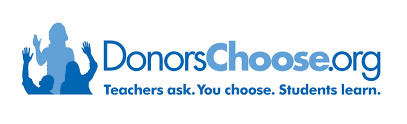

# 1. Introduction

Donorschoose.org is a US-based non-profit organization that allows individuals to donate directly to public school classroom projects.Founded in 2000 by former public school teacher Charles Best, DonorsChoose.org was among the first civic crowdfunding platforms of its kind. The organization has been given Charity Navigator’s highest rating every year since 2005.In January 2018, they announced that 1 million projects had been funded.To get students what they need to learn, the team at DonorsChoose.org needs to be able to connect donors with the projects that most inspire them.

## Problem Statement

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the assignment is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>


# 2. Importing Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

C:\Users\aksha\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\aksha\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 3.Directory List

In [2]:
import os 
os.chdir("D:\\applied AI\\Donorchoose")

# 4. About the dataset

The train_data.csv is the dataset provided by the DonorsChoose containin features as follows :-


Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


# 5. Reading the data

In [3]:
train_data=pd.read_csv("train_data.csv")
res_data=pd.read_csv("resources.csv")

In [4]:
print("number of datapoints=",train_data.shape) #shape will tell us the number of projects we have which is 109248
print("columns/atrributes name=",train_data.columns)
print(train_data.head(3))

number of datapoints= (109248, 17)
columns/atrributes name= Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')
   Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grade

In [5]:
print("datapoints in resources=",res_data.shape) 
print("attributes of resources=",res_data.columns)
print(res_data.head(3))

datapoints in resources= (1541272, 4)
attributes of resources= Index(['id', 'description', 'quantity', 'price'], dtype='object')
        id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   

    price  
0  149.00  
1   14.95  
2    8.45  


#### By looking at the shape of train_data we can see that we have around 109k projects 
#### and resources.shape tells us that we have around 15mn resources,resources can be greater than project because for each project     we can have more than resources needed

## 5.2 Data Analysis

**Counting number of projects approved and not approved

In [6]:
#Refer for documentation: https://www.geeksforgeeks.org/python-pandas-index-value_counts/
approved_not_approved=train_data['project_is_approved'].value_counts()
print(approved_not_approved)
print("*"*100)
approved_not_approved1=train_data['project_is_approved'].value_counts(normalize=True)
print("in percentage=",approved_not_approved1)

1    92706
0    16542
Name: project_is_approved, dtype: int64
****************************************************************************************************
in percentage= 1    0.848583
0    0.151417
Name: project_is_approved, dtype: float64


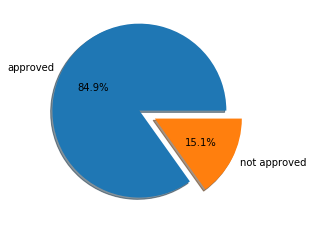

In [7]:
#how to plot a pie chart-> https://pythonspot.com/matplotlib-pie-chart/
#plt.pie documentation-> https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.pie.html

data=approved_not_approved=train_data['project_is_approved'].value_counts()
explode=(0.2,0.0)
plt.pie(data,explode=explode,labels=['approved','not approved'],shadow=True,autopct='%1.1f%%')
plt.show()

#### Graphical and Numerical Representation of total approved and rejected projects

We Could see that around 85% of projects got approved and 15% projects gets rejected and if we compare both we could say that the chances of projects getting approved is very much higher.

### 5.2.1 Univariate Analysis: School State

In [8]:
#Grouping using Groupby method
#.apply functon applies mean to the columns https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
temp = pd.DataFrame(train_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
temp.columns = ['state_code', 'num_proposals'] #changing the column headers of the temp dataframe
print("*"*50)
print(temp)

**************************************************
   state_code  num_proposals
0          AK       0.840580
1          AL       0.854711
2          AR       0.831268
3          AZ       0.838379
4          CA       0.858136
5          CO       0.841584
6          CT       0.868912
7          DC       0.802326
8          DE       0.897959
9          FL       0.831690
10         GA       0.840020
11         HI       0.856016
12         IA       0.852853
13         ID       0.835498
14         IL       0.852874
15         IN       0.845038
16         KS       0.839117
17         KY       0.863497
18         LA       0.831245
19         MA       0.860193
20         MD       0.838838
21         ME       0.847525
22         MI       0.845302
23         MN       0.857616
24         MO       0.854814
25         MS       0.845049
26         MT       0.816327
27         NC       0.855038
28         ND       0.888112
29         NE       0.841424
30         NH       0.873563
31         NJ       0

In [9]:
#plotting a choropleth maps
#refer-https://www.youtube.com/watch?v=hA39KSTb3dY
#refer-https://plot.ly/python/choropleth-maps/
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        #colorscale = scl,
        autocolorscale = True,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')


#### Summary

**By looking at the choropleth plot we can see that the states DE, ND and WA are amongst the highest states and VT,DC and TX are among the three lowest states of proposal acceptance

In [10]:
#printing states with highest and lowest project approvals in terms of percentage
#refer for documentation- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
temp.sort_values(by=['num_proposals'], ascending=False, inplace=True)
print("top 5 highest proposals")
print(temp.head(5))
print("*"*50)
print("top 5 lowest proposals")
print(temp.tail(5))

top 5 highest proposals
   state_code  num_proposals
8          DE       0.897959
28         ND       0.888112
47         WA       0.876178
35         OH       0.875152
30         NH       0.873563
**************************************************
top 5 lowest proposals
   state_code  num_proposals
18         LA       0.831245
26         MT       0.816327
43         TX       0.813142
7          DC       0.802326
46         VT       0.800000


**Numerical Representation of the choropleth graph

In [11]:
#Create a function of Stacked Bar Plot
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [12]:
#Create a function for univariate analysis
#Creating functions for code reusability
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(train_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(train_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(train_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

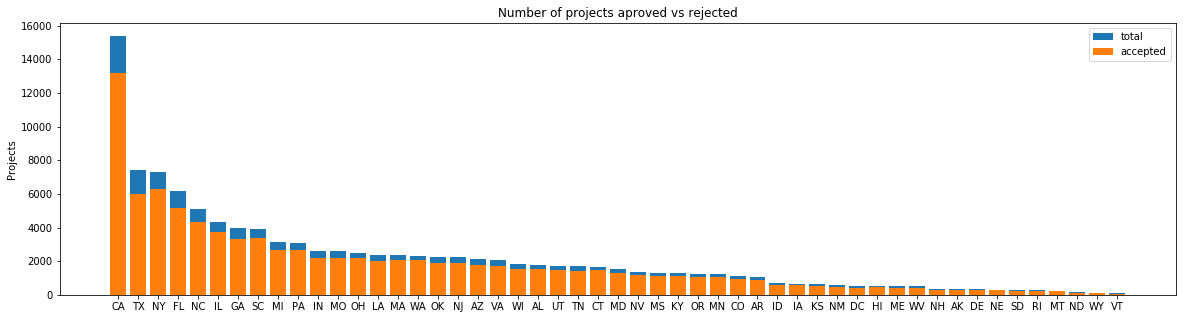

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [13]:
univariate_barplots(train_data, 'school_state', 'project_is_approved', False)

## Summary
**Every State has a 80% or greater than 80% approval Rate <br/>
**Number of projects varies for every state

### 5.2.2 Univariate Analysis of Teacher Prefix

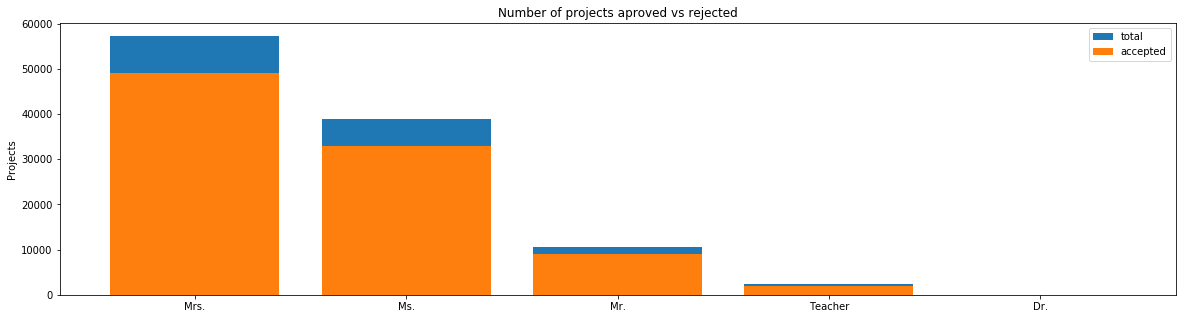

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [14]:
univariate_barplots(train_data, 'teacher_prefix', 'project_is_approved' , top=False)

# Summary
**Most of the projects are submitted by ladies(Mrs/Ms) <br/>
**Projects varies with teacher prefix

### 5.2.3 Univariate Analysis of Project Grade Category

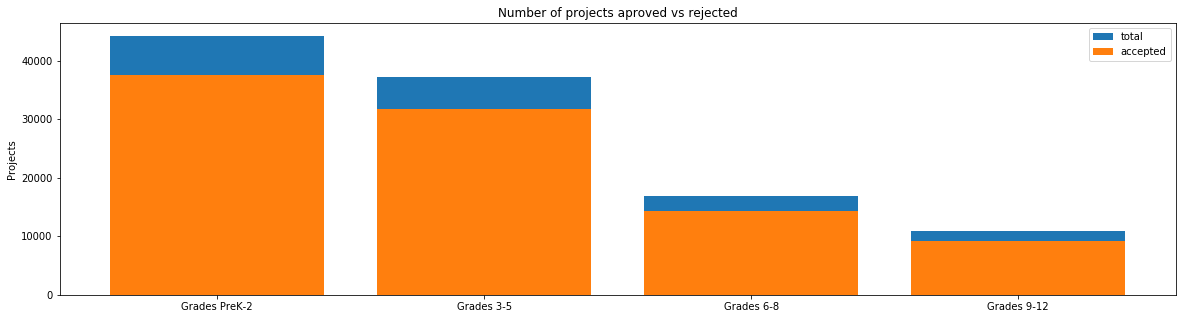

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [15]:
univariate_barplots(train_data, 'project_grade_category', 'project_is_approved', top=False)

# Summary
**Every project acceptance is around the average project acceptance <br/>
** Grades Prek-2 has highest number of projects submission. <br/>
** As one goes from Grades PreK-2 to Grades 9-12 number of project submission decreases.

### 5.2.4 Univariate Analysis of Project_Subject_Categories

**Before the analysis we have to first clean the subject categories as it contains a lot of text which we really don't required during analysis
** Removing stopwords,Special Characters etc such that after cleaning we remain with only subject categories only.

In [16]:
a=train_data['project_subject_categories'].head(5)
b=train_data['project_subject_categories'][23]
print(a)
print("="*50)
print(b)

0                    Literacy & Language
1      History & Civics, Health & Sports
2                        Health & Sports
3    Literacy & Language, Math & Science
4                         Math & Science
Name: project_subject_categories, dtype: object
Music & The Arts


**As we can see from the above example that the subject categories contains characters like &,The are present so we have to remove this first.

In [17]:
#Refer ->https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
#Refer for documentation ->https://www.programiz.com/python-programming/methods/string/strip
categories = list(train_data['project_subject_categories'].values) #creating a list of  all the values in project subject categories
clean_cat=[]
for i in categories: #taking each category at a time
    temp="" #creating a empty string
    for j in i.split(","): # splitting each word separated by a comma
        if 'The' in j.split():
            j=j.replace('The',"") #replacing the every occurence of "The" with ""
        j=j.replace(" ","") #replacing every white space with ""
        temp+=j.strip()+" " #removing all leading and trailing whitespaces and then adding a white space at the end
        temp = temp.replace('&','_') #replacing & with "_"
    clean_cat.append(temp.strip())
    #showing the result
print(clean_cat[23])

Music_Arts


In [18]:
train_data['clean_categories']=clean_cat #creating a new column as clean_categories
train_data.drop(['project_subject_categories'], axis=1,inplace=True) #dropping the subject category
print(train_data.head(2))

   Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the lim

**As we can now see that out project_subject_categories in replaced by clean_categories
Now, we can do our analysis

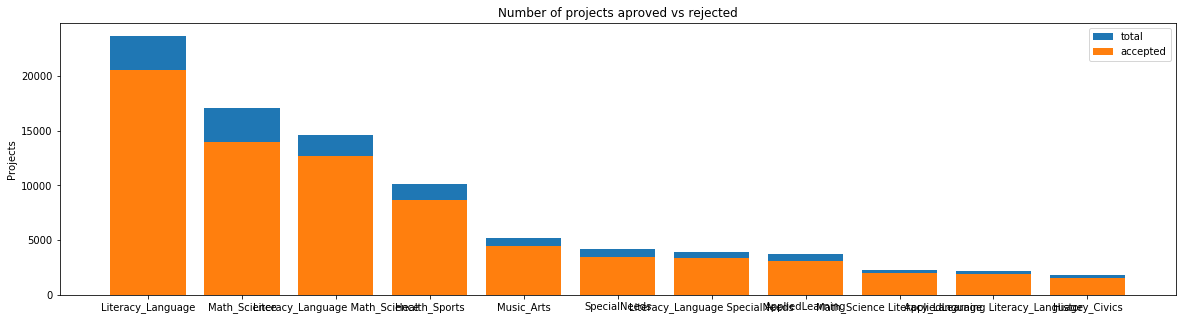

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                     clean_categories  project_is_approved  total       Avg
30     Literacy_Language SpecialNeeds                 3389   3961  0.855592
0                     AppliedLearning                 3072   3771  0.814638
36     Math_Science Literacy_Language                 1968   2289  0.859764
3   AppliedLearning Literacy_Language                 1887   2191  0.861251
16                     History_Civics                 1545   1851  0.834684


In [19]:
univariate_barplots(train_data, 'clean_categories', 'project_is_approved', top=11)
#Showing for only top 11

In [20]:
# Counting number of words in a corpus/clean_categories
#Refer ->https://stackoverflow.com/questions/8139239/how-to-count-words-in-a-corpus-document
from collections import Counter
my_counter = Counter()
for word in train_data['clean_categories'].values:
    my_counter.update(word.split())
    
print(dict(my_counter)) #printing the dictionary
sortd=sorted(my_counter.items()) #with sorted function on dictionary it sorts in aplhabetical order of value
print("="*50)
print(sortd)

{'Literacy_Language': 52239, 'History_Civics': 5914, 'Health_Sports': 14223, 'Math_Science': 41421, 'SpecialNeeds': 13642, 'AppliedLearning': 12135, 'Music_Arts': 10293, 'Warmth': 1388, 'Care_Hunger': 1388}
[('AppliedLearning', 12135), ('Care_Hunger', 1388), ('Health_Sports', 14223), ('History_Civics', 5914), ('Literacy_Language', 52239), ('Math_Science', 41421), ('Music_Arts', 10293), ('SpecialNeeds', 13642), ('Warmth', 1388)]


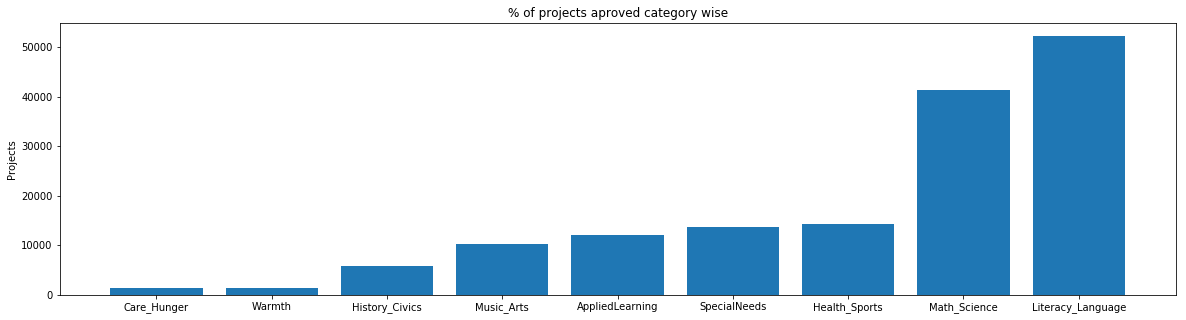

In [21]:
# Refer -> sorting dictionary in python by value : https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/
#https://www.geeksforgeeks.org/ways-sort-list-dictionaries-values-python-using-lambda-function/
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv:(kv[1] ,kv[0])))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [22]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Care_Hunger          :      1388
Warmth               :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


# Summary
1. Number of projects varies from category to category
2. Common categories on which projects are mainly proposed are literacy_language and math_science

### 5.2.5 Univariate Analysis of project_subject_subcategories

In [23]:
#Refer ->https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
#Refer for documentation ->https://www.programiz.com/python-programming/methods/string/strip
subcategories = list(train_data['project_subject_subcategories'].values) #creating a list of  all the values in project subject categories
clean_subcat=[]
for i in subcategories: #taking each category at a time
    temp="" #creating a empty string
    for j in i.split(","): # splitting each word separated by a comma
        if 'The' in j.split():
            j=j.replace('The',"") #replacing the every occurence of "The" with ""
        j=j.replace(" ","") #replacing every white space with ""
        temp+=j.strip()+" " #removing all leading and trailing whitespaces and then adding a white space at the end
        temp = temp.replace('&','_') #replacing & with "_"
    clean_subcat.append(temp.strip())
    #showing the result
print(clean_subcat[24])

AppliedSciences Mathematics


In [24]:
train_data['clean_subcategories']=clean_subcat #creating a new column as clean_categories
train_data.drop(['project_subject_subcategories'], axis=1,inplace=True) #dropping the subject category
print(train_data.head(2))

   Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4

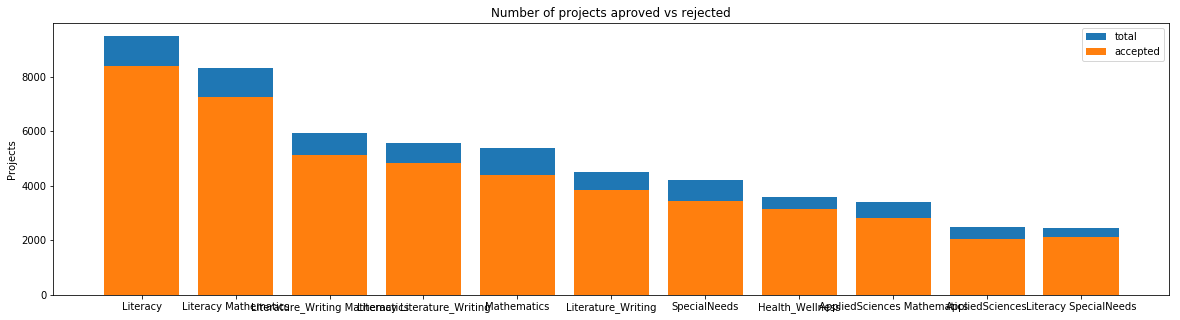

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
             clean_subcategories  project_is_approved  total       Avg
392                 SpecialNeeds                 3431   4226  0.811879
289              Health_Wellness                 3131   3583  0.873849
18   AppliedSciences Mathematics                 2824   3399  0.830833
0                AppliedSciences                 2038   2492  0.817817
326        Literacy SpecialNeeds                 2111   2440  0.865164


In [25]:
univariate_barplots(train_data, 'clean_subcategories', 'project_is_approved', top=11)

In [26]:
# Counting number of words in a corpus/clean_categories
#Refer ->https://stackoverflow.com/questions/8139239/how-to-count-words-in-a-corpus-document
from collections import Counter
my_counter1 = Counter()
for word in train_data['clean_subcategories'].values:
    my_counter1.update(word.split())
    
print(dict(my_counter1)) #printing the dictionary
sortd1=sorted(my_counter1.items()) #with sorted function on dictionary it sorts in aplhabetical order of value
print("="*50)
print(sortd1)

{'ESL': 4367, 'Literacy': 33700, 'Civics_Government': 815, 'TeamSports': 2192, 'Health_Wellness': 10234, 'Mathematics': 28074, 'Literature_Writing': 22179, 'SpecialNeeds': 13642, 'ParentInvolvement': 677, 'EnvironmentalScience': 5591, 'Health_LifeScience': 4235, 'AppliedSciences': 10816, 'EarlyDevelopment': 4254, 'Music': 3145, 'ForeignLanguages': 890, 'Other': 2372, 'Economics': 269, 'FinancialLiteracy': 568, 'Gym_Fitness': 4509, 'VisualArts': 6278, 'Warmth': 1388, 'Care_Hunger': 1388, 'SocialSciences': 1920, 'College_CareerPrep': 2568, 'CharacterEducation': 2065, 'PerformingArts': 1961, 'CommunityService': 441, 'History_Geography': 3171, 'NutritionEducation': 1355, 'Extracurricular': 810}
[('AppliedSciences', 10816), ('Care_Hunger', 1388), ('CharacterEducation', 2065), ('Civics_Government', 815), ('College_CareerPrep', 2568), ('CommunityService', 441), ('ESL', 4367), ('EarlyDevelopment', 4254), ('Economics', 269), ('EnvironmentalScience', 5591), ('Extracurricular', 810), ('FinancialL

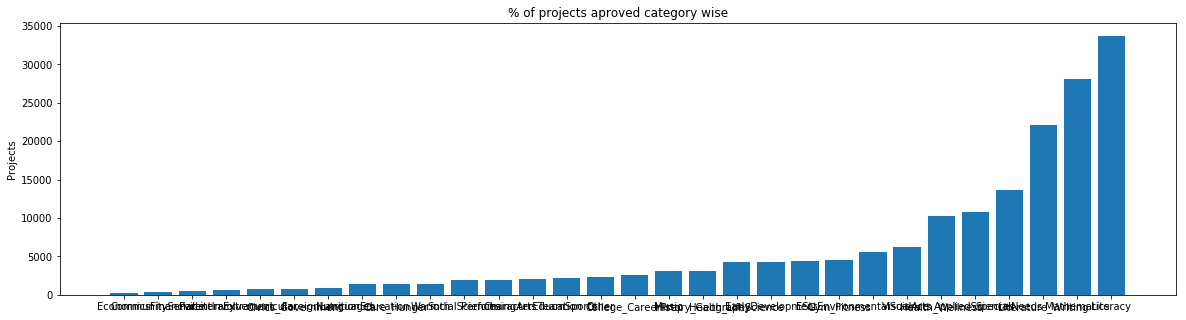

In [27]:
# Refer -> sorting dictionary in python by value : https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/
#https://www.geeksforgeeks.org/ways-sort-list-dictionaries-values-python-using-lambda-function/
subcat_dict = dict(my_counter1)
sorted_subcat_dict = dict(sorted(subcat_dict.items(), key=lambda kv:(kv[1] ,kv[0])))


ind = np.arange(len(sorted_subcat_dict)) #np.arange produces a evenly spaced ndimensional of size of len of sorted cat dict
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_subcat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_subcat_dict.keys()))
plt.show()

In [28]:
for i, j in sorted_subcat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Care_Hunger          :      1388
Warmth               :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


# Summary

1. Most of the projects come from field which teaches child how to read and write and also maths which we could assume that teaches the child basic calculations which a child might encounter on daily basis

### 5.2.6 Univariate Analysis of project_title

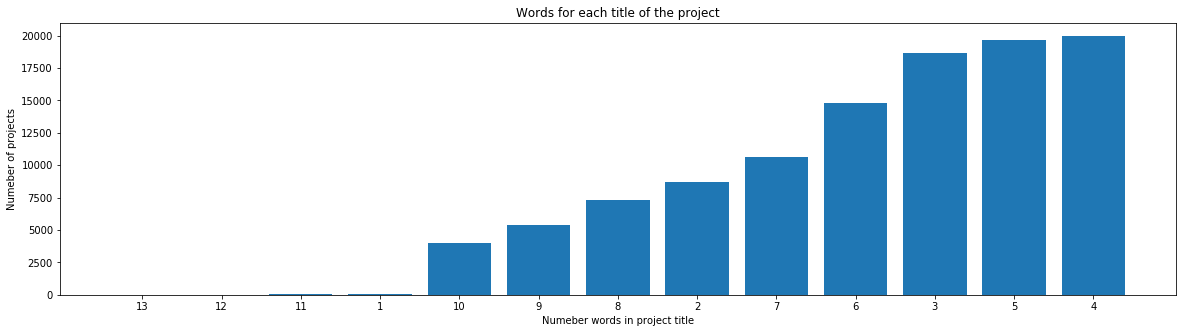

In [29]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
#Refer ->https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = train_data['project_title'].str.split().apply(len).value_counts()
word_count_dict = dict(word_count)
word_count_dict = dict(sorted(word_count_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_count_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_count_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_count_dict.keys()))
plt.show()

#### observation from above plot

We can say that most of the project title is of word length between 4-6

In [30]:
#Counting number of approved and rejected projects
approved_projects=train_data['project_is_approved'].value_counts()
print(approved_projects)

1    92706
0    16542
Name: project_is_approved, dtype: int64


In [31]:
#counting words in the acceptance and rejected columns
app_word_count=train_data[train_data['project_is_approved']==1]['project_title'].str.split().apply(len)
app_word_count=app_word_count.values

rej_word_count=train_data[train_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rej_word_count=rej_word_count.values

In [32]:
#https://www.kaggle.com/kanncaa1/plotly-tutorial-for-beginners
#https://plot.ly/python/#fundamentals

import plotly.graph_objs as go
from plotly.plotly import iplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()
init_notebook_mode(connected=True)

trace0 = go.Box(
    y=app_word_count,
    name = 'Word Count of approved projects',
    marker = dict(
        color = 'rgb(12, 12, 140)',
    )
)
trace1 = go.Box(
    y=rej_word_count,
    name = 'Word Count of rejected projects',
    marker = dict(
        color = 'rgb(12, 128, 128)',
    )
)
data = [trace0, trace1]
iplot(data)

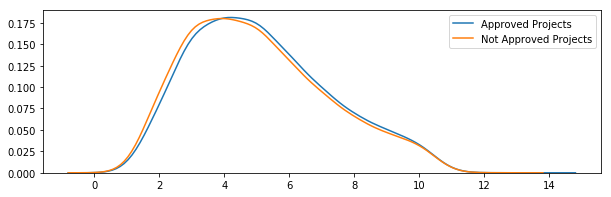

In [33]:
plt.figure(figsize=(10,3))
sns.kdeplot(app_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rej_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

# Summary
**By looking at the word counts in the accepted and the rejected projects we see that there is not much difference but accepted projects tends to have more words in their title.

### 5.2.7 Univariate Analysis of Project Essay's

**First we have to merge all the essay columns into a single column and then count the number of words in essay's of approved projects and essay's of rejected projects

In [34]:
# merge two column text dataframe: https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python
train_data["project_essay"] = train_data["project_essay_1"].map(str) +train_data["project_essay_2"].map(str)+train_data["project_essay_3"].map(str) +  train_data["project_essay_4"].map(str)
            #Here the .map(str) converts string to all the coulmns in project_eassy_1/2/3/4
print(train_data['project_essay'].head(3))

0    My students are English learners that are work...
1    Our students arrive to our school eager to lea...
2    \r\n\"True champions aren't always the ones th...
Name: project_essay, dtype: object


In [35]:
approved_word_count = train_data[train_data['project_is_approved']==1]['project_essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = train_data[train_data['project_is_approved']==0]['project_essay'].str.split().apply(len)
rejected_word_count= rejected_word_count.values

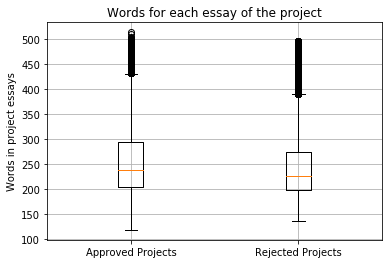

In [36]:
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()



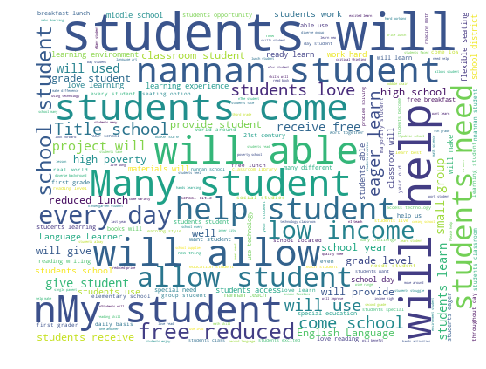

In [37]:
#Word Cloud of accepted project essay
from wordcloud import WordCloud
x = train_data[train_data['project_is_approved']==1]['project_essay']
text = " ".join(review for review in x)
plt.subplots(figsize=(8,8))
wordcloud = WordCloud(
                      background_color='white',
                      width=512,
                      height=384
                         ).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('graph.png')

plt.show()

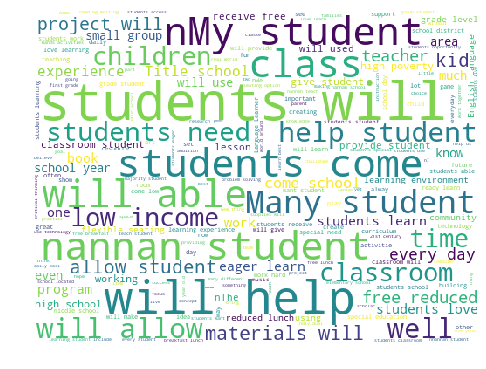

In [38]:
#Word Cloud of rejected project essay
from wordcloud import WordCloud
y = train_data[train_data['project_is_approved']==0]['project_essay']
text1 = " ".join(review for review in y)
plt.subplots(figsize=(8,8))
wordcloud = WordCloud(
                      background_color='white',
                      width=512,
                      height=384
                         ).generate(text1)
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('graph.png')

plt.show()

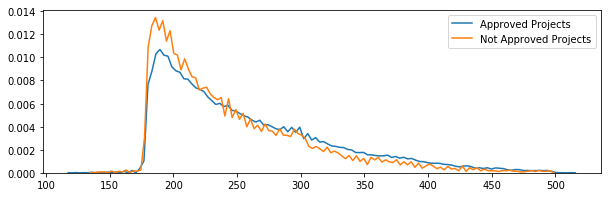

In [39]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

# Summary
1. By Looking at the boxplot and distribution plot we can see that distribution of number of words in a essay of accepted projects is slightly more than those which are not accepted
2. By looking at the word cloud we can say that words are nearly the same in both accepted and rejected project essays

### 5.2.8 Univariate analysis of Cost per Project

In [40]:
res_data.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [41]:
res_data.columns

Index(['id', 'description', 'quantity', 'price'], dtype='object')

In [42]:
#Refer-> https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

price_data = res_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index() #grouping is done on the basis of ids and agggreating the sum of price and quantity column
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [43]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html?highlight=merge#pandas.merge
train_data = train_data.merge(price_data, on='id', how='left')
print(train_data.head(1))

   Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   

    clean_categories clean_subcategories  \
0  Litera

In [44]:
approved_project_price = train_data[train_data['project_is_approved']==1]['price'].values

rejected_project_price = train_data[train_data['project_is_approved']==0]['price'].values

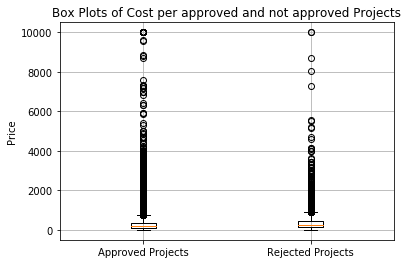

In [45]:
plt.boxplot([approved_project_price, rejected_project_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()



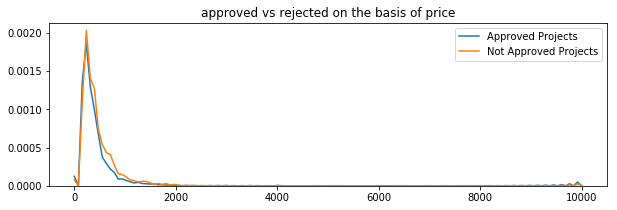

In [46]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_project_price,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_project_price,label="Not Approved Projects", bw=0.6)
plt.title("approved vs rejected on the basis of price")
plt.legend()
plt.show()


In [47]:
#Refer->http://zetcode.com/python/prettytable/
#Refer->https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.percentile.html
#Refer->https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.round_.html
from prettytable import PrettyTable
x=PrettyTable()

x.field_names=["Percentile", "Approved Projects", "Rejected Projects"] #column headers

for i in range(0,101,5): #calculating every 5th percentile value
    x.add_row([i,np.round(np.percentile(approved_project_price,i), 3),np.round(np.percentile(rejected_project_price,i), 3)])
print(x)
#add_row takes three argument i comes under percentile and the other two comes under approved and rejected projects respectively
#np.percentile calculates the percentile value 
#np.round rounds off the percentile to 3

+------------+-------------------+-------------------+
| Percentile | Approved Projects | Rejected Projects |
+------------+-------------------+-------------------+
|     0      |        0.66       |        1.97       |
|     5      |       13.59       |        41.9       |
|     10     |       33.88       |       73.67       |
|     15     |        58.0       |       99.109      |
|     20     |       77.38       |       118.56      |
|     25     |       99.95       |      140.892      |
|     30     |       116.68      |       162.23      |
|     35     |      137.232      |      184.014      |
|     40     |       157.0       |      208.632      |
|     45     |      178.265      |      235.106      |
|     50     |       198.99      |      263.145      |
|     55     |       223.99      |       292.61      |
|     60     |       255.63      |      325.144      |
|     65     |      285.412      |       362.39      |
|     70     |      321.225      |       399.99      |
|     75  

# Summary
**By looking at the pretty table it is clearly seen that for price for accepted projects is lower than that of rejected project for every percentile instance.

### 5.2.9 Univariate analysis of teacher_number_of_previously_posted_projects

In [48]:
approved_project_previous = train_data[train_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].values

rejected_project_previous = train_data[train_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].values


In [49]:
print(train_data[train_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].mean())

print("="*50)
print(train_data[train_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].mean())

11.914126378012211
6.888526175794946


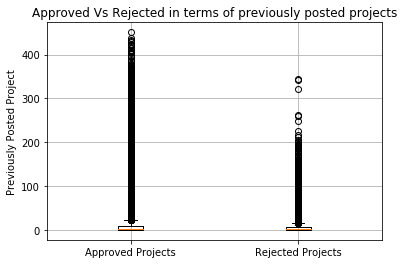

In [50]:
plt.boxplot([approved_project_previous, rejected_project_previous])
plt.title('Approved Vs Rejected in terms of previously posted projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Previously Posted Project')
plt.grid()
plt.show()




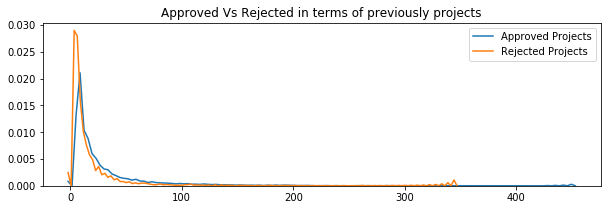

In [51]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_project_previous,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_project_previous,label="Rejected Projects", bw=0.6)
plt.title("Approved Vs Rejected in terms of previously projects")
plt.legend()
plt.show()

# Summary
1. Projects are more likely to be accepted if the teacher has previously posted around 11-12(mean) or more
2. Projects are less likely to be accepted if the teacher has previously posted around 5-6(mean) or less 
3. As from the graph also we can see that the distribution of accepted projects is slightly more than that of rejected

### 5.2.10 Univariate analysis of project_resource_summary

In [52]:
def num_present(text): 
    return any(i.isdigit() for i in text)



no_rows = train_data.shape[0] #getting the row value in no_rows
#train_data is of 109248 X 18 shape and with [0] it gives the row value i.e. 109248

# Creating a new list with 1(if we have a number present in 'project_resource_summary') else 0 for every summary
num_digits_present = [1 if num_present(train_data['project_resource_summary'].values[i]) else 0 for i in range(no_rows)]

# Creating a new field called previously_posted_projects 
train_data['num_digits_present'] =  num_digits_present

train_data['num_digits_present'].value_counts()



0    93492
1    15756
Name: num_digits_present, dtype: int64

In [53]:
train_data['num_digits_present'].value_counts(normalize=True)

0    0.855778
1    0.144222
Name: num_digits_present, dtype: float64

##### We can see that summary which includes numerical value is very low approximately 15% as compared to 85%

In [54]:
x1=train_data[train_data['num_digits_present']==1]['project_is_approved'].value_counts(normalize=True)
print(x1)
print("="*50)
y1=train_data[train_data['num_digits_present']==0]['project_is_approved'].value_counts(normalize=True)
print(y1)

1    0.894263
0    0.105737
Name: project_is_approved, dtype: float64
1    0.840885
0    0.159115
Name: project_is_approved, dtype: float64


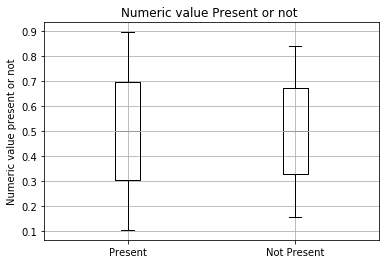

In [55]:
plt.boxplot([x1,y1])
plt.title('Numeric value Present or not ')
plt.xticks([1,2],('Present','Not Present'))
plt.ylabel('Numeric value present or not')
plt.grid()
plt.show()


## Summary

1. When Numerical Value is present in the summary the project acceptance rate is around 90% as compared to 85% project acceptance when numerical value not present. So we can see their higher chances of project getting accepted if the project resource summary contains numerical value but chances are not very high

## 5.3 Text Preprocessing

### 5.3.1. Essay Text

In [56]:
# printing some random essays.
print(train_data['project_essay'].values[10])
print("="*50)
print(train_data['project_essay'].values[20000])
print("="*50)
print(train_data['project_essay'].values[942])
print("="*50)
print(train_data['project_essay'].values[451])
print("="*50)
print(train_data['project_essay'].values[99999])
print("="*50)


\"There are many little ways to enlarge your world. Love of books is the best of all.” - Jacqueline Kennedy\r\n\r\nI work at a Title 1 school which serves students of lower income families.\r\nThey often enter 5th grade reading at a second grade level with the notion that reading is just another thing they're not good at. I provide them with the motivation to want to pick up a book, snuggle up on a bean bag, and read more than they ever have in their lifetime.I've had 8 sets of students enjoy the books in our classroom library throughout the past few years, and as a result most of them are falling apart. It is a testament to how much they have loved reading but unfortunately the books will soon need to be retired. With the purchase of these new books, you will ensure that the joy of reading continues on past this school year. A Haunted Mystery Series, Word of Mouse, and The Babysitters Club are just a few books my students would love to read. \r\n\r\nMy students struggle with building 

In [57]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [58]:
test = decontracted(train_data['project_essay'].values[20000])
print(test)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [59]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
test = test.replace('\\r', ' ')
test = test.replace('\\"', ' ')
test = test.replace('\\n', ' ')
print(test)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [60]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
test = re.sub('[^A-Za-z0-9]+', ' ', test) #square bracket creates either or set; + signifes 1 or more character
print(test)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [61]:
s=set(stopwords.words('english'))
print(s)

{'here', 'i', 'to', 'out', 'why', 'being', 'had', 'most', 'own', 'nor', 's', 'more', "she's", 'some', 'other', 'who', 'during', 'ours', 'all', 'been', 're', 'itself', 'am', 'hadn', 'while', 'shouldn', "mustn't", 'our', 'each', 'off', 'how', 'and', 'few', 'an', 't', 'this', 'from', 'then', 'needn', 'her', 'or', 'don', "you'll", 'into', 'under', 'ma', 'hers', 'is', "it's", 'him', 'your', 'up', 'which', 'now', 'as', 'only', "haven't", 'can', "you'd", 'at', 'between', "wasn't", 'further', 'he', 'she', 'd', 'will', 'but', 'hasn', 'such', 'with', "couldn't", 'theirs', "you're", 'they', 'for', 'no', 'doing', 'o', 'ain', 'myself', 'about', "wouldn't", 'because', "mightn't", "shouldn't", 'over', 'wouldn', 'its', 'that', "you've", 'these', 'yourselves', 'won', 'so', 'aren', 'isn', "won't", 'before', 'very', 'themselves', 'ourselves', 'mightn', 'any', 'yours', "doesn't", 'shan', 'whom', 'again', 'against', 'there', 'do', 'by', 'weren', 'the', "shan't", 'just', 'it', 'my', 'you', 'too', 'down', 'b

In [62]:
#Combining all the above statments to transform our text in a clean text
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(train_data['project_essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in s)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:04<00:00, 1696.86it/s]


In [63]:
#printing the text after preprocessing
preprocessed_essays[0]

'my students english learners working english second third languages we melting pot refugees immigrants native born americans bringing gift language school we 24 languages represented english learner program students every level mastery we also 40 countries represented families within school each student brings wealth knowledge experiences us open eyes new cultures beliefs respect the limits language limits world ludwig wittgenstein our english learner strong support system home begs resources many times parents learning read speak english along side children sometimes creates barriers parents able help child learn phonetics letter recognition reading skills by providing dvd players students able continue mastery english language even one home able assist all families students within level 1 proficiency status offered part program these educational videos specially chosen english learner teacher sent home regularly watch the videos help child develop early reading skills parents access

### 5.3.2 Project title text

In [64]:
# Printing some random project title
# printing some random essays.
print(train_data['project_title'].values[7])
print("="*50)
print(train_data['project_title'].values[9])
print("="*50)
print(train_data['project_title'].values[16])
print("="*50)
print(train_data['project_title'].values[23])
print("="*50)

It's the 21st Century
Just For the Love of Reading--\r\nPure Pleasure
Making Great LEAP's With Leapfrog!
Instrumental Power: Conquering STEAM!


In [65]:
#1.Decontraction
test1 = decontracted(train_data['project_title'].values[7])
print(test1)
print("="*50)

It is the 21st Century


In [66]:
#2. Removing newline breakline etc
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
test1 = test1.replace('\\r', ' ')
test1= test1.replace('\\"', ' ')
test1= test1.replace('\\n', ' ')
print(test1)

It is the 21st Century


In [67]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
test1 = re.sub('[^A-Za-z0-9]+', ' ', test1) #square bracket creates either or set; + signifes 1 or more character
print(test1)

It is the 21st Century


In [68]:
test1=test1.lower()

In [69]:
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for title in tqdm(train_data['project_title'].values):
    test1 = decontracted(title)
    test1 = test1.replace('\\r', ' ')
    test1 = test1.replace('\\"', ' ')
    test1 = test1.replace('\\n', ' ')
    test1 = re.sub('[^A-Za-z0-9]+', ' ', test1)
    # https://gist.github.com/sebleier/554280
    test1 = ' '.join(e for e in test1.split() if e not in s)
    preprocessed_title.append(test1.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:06<00:00, 17361.43it/s]


In [70]:
preprocessed_title[0]

'educational support english learners home'

## 5.4 Preparing Data For Models

In [71]:
train_data.dtypes

Unnamed: 0                                        int64
id                                               object
teacher_id                                       object
teacher_prefix                                   object
school_state                                     object
project_submitted_datetime                       object
project_grade_category                           object
project_title                                    object
project_essay_1                                  object
project_essay_2                                  object
project_essay_3                                  object
project_essay_4                                  object
project_resource_summary                         object
teacher_number_of_previously_posted_projects      int64
project_is_approved                               int64
clean_categories                                 object
clean_subcategories                              object
project_essay                                   

### We are going to consider features which will be useful for our modelling
-Categorical Datatypes includes:
. School State
. clean categories
. clean subcategories
. project grade categories
. teacher prefix

**We will apply techniques such one hot encoding and binary encoding for categorical datatypes

-Text Data or Object Data includes:
. project title
. text
. project resource summary

**We will apply techniques like BOW, tf-idf, w2v, avg-w2v, wt-tfidf

-Numerical or integer type data includes:
. quantity
. teacher number of previously posted projects
. price

**We will apply normalization technique to normalize the data

### 5.4.1 Categorical Features(one-hot encoding technique)

#### 5.4.1.1 Category Feature

In [72]:
# we use count vectorizer to convert the values into one hot encoded features
#Clean Categories
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(train_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(train_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Care_Hunger', 'Warmth', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


#### 5.4.1.2 Sub-Category Feature

In [73]:
# we use count vectorizer to convert the values into one hot encoded features
#Clean Subcategories
vectorizer = CountVectorizer(vocabulary=list(sorted_subcat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(train_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(train_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Care_Hunger', 'Warmth', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


#### 5.4.1.3 School-State Feature

In [74]:
#Feature Encoding for School State
#CountVectorizer is used to convert text in one hot encoded matrix

vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(train_data['school_state'].values)
print(vectorizer.get_feature_names())


school_state_one_hot = vectorizer.transform(train_data['school_state'].values)
print("Shape of matrix after one hot encodig ",school_state_one_hot.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix after one hot encodig  (109248, 51)


#### 5.4.1.4 Teacher-Prefix Feature

In [75]:
#Feature Encoding for Teacher Prefix
#CountVectorizer is used to convert text in one hot encoded matrix
print(train_data['teacher_prefix'].value_counts())
print("="*50)
x=57269+38955+10648+2360+13
print(x)
print("="*50)
print(train_data['teacher_prefix'].shape)
#by looking at the x and shape we see that 3 columns which have missing values
# we fill these values using fillna function

train_data['teacher_prefix']= train_data['teacher_prefix'].fillna('missing')
print("="*50)
print(train_data['teacher_prefix'].value_counts())

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64
109245
(109248,)
Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
missing        3
Name: teacher_prefix, dtype: int64


In [76]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(train_data['teacher_prefix'].values)
print(vectorizer.get_feature_names())


teacher_prefix_one_hot = vectorizer.transform(train_data['teacher_prefix'].values)
print("Shape of matrix after one hot encodig ",teacher_prefix_one_hot.shape)

['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher', 'missing']
Shape of matrix after one hot encodig  (109248, 6)


#### 5.4.1.5 Project-Grade Feature

In [77]:
train_data['project_grade_category'].isnull().sum() #finds the number of null values present in the project grade category

0

In [78]:
#counting number of words in the project grade category and then coverting into dictionary
#Refer ->https://stackoverflow.com/questions/8139239/how-to-count-words-in-a-corpus-document
from collections import Counter
my_counter1 = Counter()
for word in train_data['project_grade_category'].values:
    my_counter1.update(word.split())
    
#converting to dictionary
project_grade_dict=dict(my_counter1)
#Now sorting the dictionary
sorted_project_grade_dict = dict(sorted(project_grade_dict.items(), key=lambda kv:(kv[1] ,kv[0])))

In [79]:
print(sorted_project_grade_dict)

{'9-12': 10963, '6-8': 16923, '3-5': 37137, 'PreK-2': 44225, 'Grades': 109248}


In [80]:
#How to remove values from a dictionary in python-> https://thispointer.com/different-ways-to-remove-a-key-from-dictionary-in-python/
if 'Grades' in sorted_project_grade_dict:
    del sorted_project_grade_dict['Grades']

print("Updated Dictionary :" , sorted_project_grade_dict)  

Updated Dictionary : {'9-12': 10963, '6-8': 16923, '3-5': 37137, 'PreK-2': 44225}


In [81]:
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(train_data['project_grade_category'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(train_data['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['9-12', '6-8', '3-5', 'PreK-2']
Shape of matrix after one hot encodig  (109248, 4)


### 5.4.2 Vectorizing Text Data

#### 5.4.2.1 Bag of Words

##### 5.4.2.1.1 BOW of Project_Essay

In [82]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix",text_bow.shape)

Shape of matrix (109248, 16623)


##### 5.4.2.1.2 BOW of project_title

In [83]:
vectorizer = CountVectorizer(min_df=10)
text_bow_title= vectorizer.fit_transform(preprocessed_title)
print("Shape of matrix ",text_bow_title.shape)

Shape of matrix  (109248, 3329)


In [84]:
#Combining both the text(project essay and project title into one and then performing bow 
pro_title= preprocessed_essays + preprocessed_title
#Checking if they get combined or not
print(len(pro_title))
print(len(preprocessed_essays))
print(len(preprocessed_title))


218496
109248
109248


In [85]:
vectorizer = CountVectorizer(min_df=10)
text_bow_total= vectorizer.fit_transform(pro_title)
print("Shape of matrix ",text_bow_total.shape)

Shape of matrix  (218496, 17096)


In [86]:
#Since the size of the tota text matrix is diiferent so we have to convert it into the required shape so that we can merge with other features
#A bit to calculation is required befofe reshaping it to avoid mismatching of total elements
#we have total elements= 218496*17096 and we have to convert it into 109248*(something dimension)
#to find that something we have to divide the total elements with 109248 and we got that something as 34192

#How to reshape the sparse matrix-> https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.reshape.html
print(type(text_bow_total))
text_bow_total1=text_bow_total.reshape((109248,34192))
print(text_bow_total1.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(109248, 34192)


#### 5.4.2.2 Tf-idf vectorizer

##### 5.4.2.2.1 Tf-idf of Project_Essays

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf_essay = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix ",text_tfidf_essay.shape)

Shape of matrix  (109248, 16623)


##### 5.4.2.2.2 Tf-idf of Project_Title

In [88]:
#Refer-> https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10) #df tells us that we will only consider those words which is present atleast in 10 documents
text_tfidf_title = vectorizer.fit_transform(preprocessed_title)
print("Shape of matrix  ",text_tfidf_title.shape)

Shape of matrix   (109248, 3329)


In [89]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10) #df tells us that we will only consider those words which is present atleast in 10 documents
text_tfidf_total = vectorizer.fit_transform(pro_title)
print("Shape of matrix  ",text_tfidf_total.shape)

Shape of matrix   (218496, 17096)


In [90]:
text_tfidf_total1=text_tfidf_total.reshape((109248,34192))
print(text_tfidf_total1.shape)

(109248, 34192)


#### 5.4.2.3 Average word2vector(avg w2v)

In [91]:
#https://stackoverflow.com/questions/49083826/get-trouble-to-load-glove-840b-300d-vector
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding='utf8')
    model = {}
    for line in tqdm(f):
        splitLine = line.split(' ')
        word = splitLine[0]
        embedding = np.asarray(splitLine[1:], dtype='float32')
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model


In [92]:
model = loadGloveModel('glove.840B.300d.txt')

Loading Glove Model



Done. 2196016  words loaded!


In [93]:
words = []
for i in pro_title:
    words.extend(i.split(' ')) #The extend() extends the list by adding all items of a list (passed as an argument) to the end. 

    
    
#for i in preprocessed_title:
#    words.extend(i.split(' '))
print("all the words in the corpus", len(words))
words = set(words)
print("the unique words in the corpus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our corpus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_corpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_corpus[i] = model[i]
print("word 2 vec length", len(words_corpus))

all the words in the corpus 16871832
the unique words in the corpus 58968
The number of words that are present in both glove vectors and our corpus 48227 ( 81.785 %)
word 2 vec length 48227


In [94]:
import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_corpus, f) # save training datasets into a pickle file for machine learning


In [95]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [96]:
# average Word2Vec
# compute average word2vec for each essays.

from tqdm import tqdm_notebook as tqdm
avg_w2v_vectors = []; # the avg-w2v for each essays is stored in this list
for sentence in tqdm(preprocessed_essays): # for each essay
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the essay
    for word in sentence.split(): # for each word in a esssay
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))


109248
300


In [97]:
# compute average word2vec 
# computing for project title
#even after using tqdm my output gets crumbled->https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook/42218684
from tqdm import tqdm_notebook as tqdm

avg_w2v_vectors_title = []; # the avg-w2v for each project title is stored in this list
for sentence in tqdm(preprocessed_title): # for each title
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the title
    for word in sentence.split(): # for each word in a title
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_title.append(vector)

print(len(avg_w2v_vectors_title))
print(len(avg_w2v_vectors_title[0]))


109248
300


In [98]:
# compute average word2vec
# computing for each combination of title and essay
#even after using tqdm my output gets crumbled->https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook/42218684
from tqdm import tqdm_notebook as tqdm

avg_w2v_vectors_total = []; # the avg-w2v for each project text is stored in this list
for sentence in tqdm(pro_title): # for each text
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the text
    for word in sentence.split(): # for each word in a text
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_total.append(vector)

print(len(avg_w2v_vectors_total))
print(len(avg_w2v_vectors_total[0]))


218496
300


In [99]:
#Converting inot matrix of required format
avg_w2v_vectors_total=np.array([avg_w2v_vectors_total])

avg_w2v_vectors_total1=avg_w2v_vectors_total.reshape((109248,600))

In [100]:
print(avg_w2v_vectors_total1.shape)


(109248, 600)


#### 5.4.2.4 TFIDF weighted Word2vec

##### Using Pretrained Model for finding the tf-idf weighted word2vec

In [101]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [102]:
# compute average word2vec for each review.
from tqdm import tqdm_notebook as tqdm
tfidf_w2v_vectors_essay = []; # the avg-w2v for each sentence
for sentence in tqdm(preprocessed_essays): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_essay.append(vector)

print(len(tfidf_w2v_vectors_essay))
print(len(tfidf_w2v_vectors_essay[0]))


109248
300


In [103]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [104]:
from tqdm import tqdm_notebook as tqdm
tfidf_w2v_vectors_title = []; # the avg-w2v for each sentence
for sentence in tqdm(preprocessed_title): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_title.append(vector)

print(len(tfidf_w2v_vectors_title))
print(len(tfidf_w2v_vectors_title[0]))


109248
300


In [105]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(pro_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [106]:
from tqdm import tqdm_notebook as tqdm
tfidf_w2v_vectors_total = []; # the avg-w2v for each sentence
for sentence in tqdm(pro_title): # for each sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence.split(): # for each word in a sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_total.append(vector)

print(len(tfidf_w2v_vectors_total))
print(len(tfidf_w2v_vectors_total[0]))


218496
300


In [107]:
tfidf_w2v_vectors_total=np.array([tfidf_w2v_vectors_total])

tfidf_w2v_vectors_total1=tfidf_w2v_vectors_total.reshape((109248,600))

In [108]:
print(tfidf_w2v_vectors_total1.shape)

(109248, 600)


### 5.4.3 Normalizing Numerical Features

#### 5.4.3.1 Price Feature

In [109]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit_transform
#https://stackoverflow.com/questions/30668223/how-to-change-array-shapes-in-in-numpy
from sklearn.preprocessing import StandardScaler
price_scalar = StandardScaler()
price_scalar.fit(train_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(train_data['price'].values.reshape(-1, 1))
print('='*50)
print(price_standardized)

Mean : 298.1193425966608, Standard deviation : 367.49634838483496
[[-0.3905327 ]
 [ 0.00239637]
 [ 0.59519138]
 ...
 [-0.15825829]
 [-0.61243967]
 [-0.51216657]]


#### 5.4.3.2 Quantity Feature

In [110]:
#What does -1 mean in a reshape function->https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
from sklearn.preprocessing import StandardScaler
quantity_scalar = StandardScaler()
quantity_scalar.fit(train_data['quantity'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
quantity_standardized = quantity_scalar.transform(train_data['quantity'].values.reshape(-1, 1))
print('='*50)
print(quantity_standardized)

C:\Users\aksha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Mean : 16.965610354422964, Standard deviation : 26.182821919093175


C:\Users\aksha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



[[ 0.23047132]
 [-0.60977424]
 [ 0.19227834]
 ...
 [-0.4951953 ]
 [-0.03687954]
 [-0.45700232]]


#### 5.4.3.3 Teacher number of previously posted projects

In [111]:
from sklearn.preprocessing import StandardScaler
tnp_scalar = StandardScaler()
tnp_scalar.fit(train_data["teacher_number_of_previously_posted_projects"].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {tnp_scalar.mean_[0]}, Standard deviation : {np.sqrt(tnp_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
tnp_standardized = tnp_scalar.transform(train_data["teacher_number_of_previously_posted_projects"].values.reshape(-1, 1))
print('='*50)
print(tnp_standardized)

C:\Users\aksha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



Mean : 11.153165275336848, Standard deviation : 27.77702641477403


C:\Users\aksha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



[[-0.40152481]
 [-0.14951799]
 [-0.36552384]
 ...
 [-0.29352189]
 [-0.40152481]
 [-0.40152481]]


### 5.4.4 Merging all the above features into one

##### Merging all the numerical,text and categorical features

In [114]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(school_state_one_hot.shape)
print(teacher_prefix_one_hot.shape)
print(categories_one_hot.shape)
print(text_bow_total.shape)
print(text_bow_title.shape)
print(text_bow.shape)
print(text_tfidf_total.shape)
print(text_tfidf_essay.shape)
print(text_tfidf_title.shape)
print(price_standardized.shape)
print(quantity_standardized.shape)
print(tnp_standardized .shape)

(109248, 4)
(109248, 30)
(109248, 51)
(109248, 6)
(109248, 4)
(218496, 17096)
(109248, 3329)
(109248, 16623)
(218496, 17096)
(109248, 16623)
(109248, 3329)
(109248, 1)
(109248, 1)
(109248, 1)


#### 5.4.4.1 BOW

In [115]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#merging all the categorical,numerical features with bow of total text 
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X1 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,text_bow_total1, price_standardized,quantity_standardized,tnp_standardized))
X1.shape
print(type(X1))
print(X1.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 34239)


In [116]:
#merging all the categorical,numerical features with bow of essay text 
X2 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,text_bow, price_standardized,quantity_standardized,tnp_standardized))
X2.shape
print(type(X2))
print(X2.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 16670)


In [117]:
#merging all the categorical,numerical features with bow of essay text 
X3 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,text_bow_title, price_standardized,quantity_standardized,tnp_standardized))
X3.shape
print(type(X3))
print(X3.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 3376)


##### similarly we have to combine all the numerical+ categorical features with text tf-idf and text word2vec 

#### 5.4.4.2 Tf-IDF

In [118]:
#merging all the categorical,numerical features with tfidf of total text 
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X4 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,text_tfidf_total1, price_standardized,quantity_standardized,tnp_standardized))
X4.shape
print(type(X4))
print(X4.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 34239)


In [119]:
#merging all the categorical,numerical features with tfidf of essay text 
X5 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,text_tfidf_essay, price_standardized,quantity_standardized,tnp_standardized))
X5.shape
print(type(X5))
print(X5.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 16670)


In [120]:
#merging all the categorical,numerical features with tfidf of title text 
X6 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,text_tfidf_title, price_standardized,quantity_standardized,tnp_standardized))
X6.shape
print(type(X6))
print(X6.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 3376)


#### 5.4.4.3 Avg word2vec

In [121]:
#merging all the categorical,numerical features with avg word2vec of essay text 
X7 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,avg_w2v_vectors, price_standardized,quantity_standardized,tnp_standardized))
X7.shape
print(type(X7))
print(X7.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 347)


In [122]:
#merging all the categorical,numerical features with avg word2vec of title text 
X8 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,avg_w2v_vectors_title, price_standardized,quantity_standardized,tnp_standardized))
X8.shape
print(type(X8))
print(X8.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 347)


In [123]:
#merging all the categorical,numerical features with avg word2vec of total text 
X9 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,avg_w2v_vectors_total1, price_standardized,quantity_standardized,tnp_standardized))
X9.shape
print(type(X9))
print(X9.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 647)


#### 5.4.4.4 Weighted word2vec

In [124]:
#merging all the categorical,numerical features with weighted word2vec of essay text 
X10 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,tfidf_w2v_vectors_essay, price_standardized,quantity_standardized,tnp_standardized))
print(type(X10))
print(X10.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 347)


In [125]:
#merging all the categorical,numerical features with weighted word2vec of title text 
X11 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,tfidf_w2v_vectors_title, price_standardized,quantity_standardized,tnp_standardized))
print(type(X11))
print(X11.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 347)


In [126]:
#merging all the categorical,numerical features with weighted word2vec of total text 
X12 = hstack((categories_one_hot, sub_categories_one_hot,teacher_prefix_one_hot,categories_one_hot,tfidf_w2v_vectors_total1, price_standardized,quantity_standardized,tnp_standardized))
print(type(X12))
print(X12.shape)

<class 'scipy.sparse.coo.coo_matrix'>
(109248, 647)


# 6. Applying tSNE

## 6.1 tsne with BOW

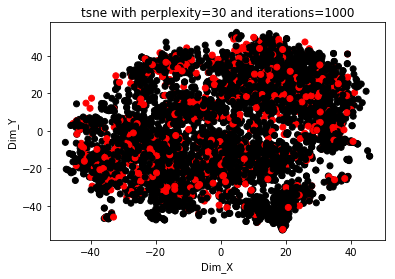

In [127]:
#taking only 5000 datapoints
#coo_matrix' object is not subscriptable-> https://stackoverflow.com/questions/30163830/accessing-elements-in-coo-matrix
#https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2904/code-example-of-t-sne/2/module-2-data-science-exploratory-data-analysis-and-data-visualization
#series has no object as reshape-> https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape
from sklearn.manifold import TSNE
import seaborn as sn
X3=X3.tocsr()
X_5000=X3[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

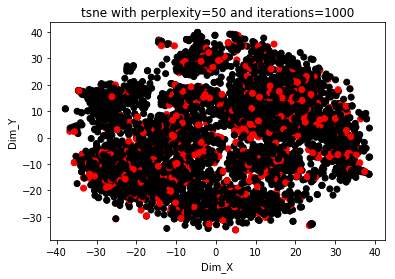

In [128]:
X3=X3.tocsr()
X_5000=X3[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50)
#no of components=2
#learning rate=200
#perplexity=50
#default number of iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=1000")
plt.show()

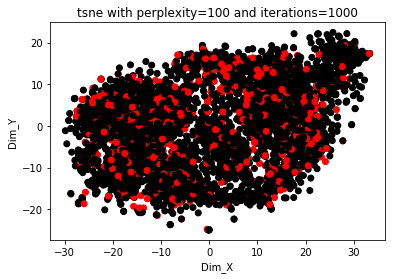

In [129]:
X3=X3.tocsr()
X_5000=X3[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=100)
#no of components=2
#learning rate=200
#perplexity=100
#default number of iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=100 and iterations=1000")
plt.show()

#### There is not much change on changing the perplexity from 30-100; Now let's see what happens on changing the iterations on a fixed perplexity of 50

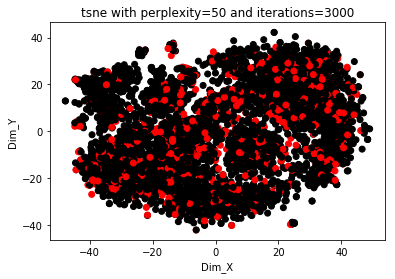

In [130]:
X3=X3.tocsr()
X_5000=X3[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=3000)
#no of components=2
#learning rate=200
#perplexity=50
#number of iterations=3000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=3000")
plt.show()

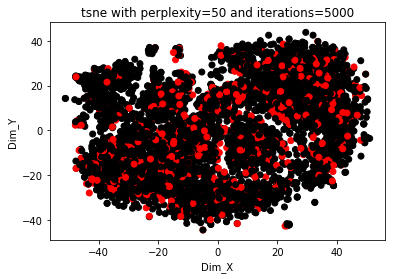

In [131]:
n_iter=1000
X3=X3.tocsr()
X_5000=X3[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#no of components=2
#learning rate=200
#perplexity=50
#number of iterations=5000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=5000")
plt.show()

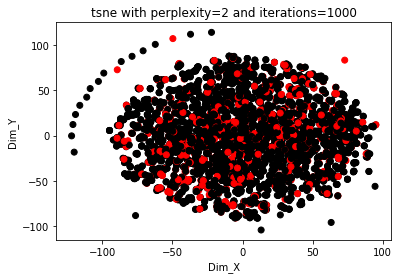

In [132]:
X3=X3.tocsr()
X_5000=X3[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=2,n_iter=1000)
#no of components=2
#learning rate=200
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=2 and iterations=1000")
plt.show()

## Summary
1. We see some clusters of red and black points but most of the points are overlapped
2. On changing the perplexity and iterations we are still unable to derive meaningful information the tsne plot

## 6.2 tSNE with TF-IDF

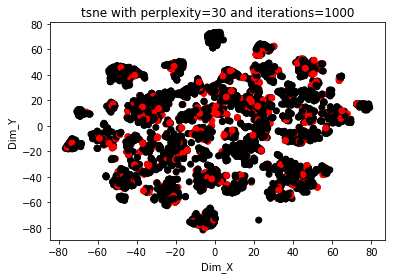

In [133]:
#taking only 5000 datapoints
#coo_matrix' object is not subscriptable-> https://stackoverflow.com/questions/30163830/accessing-elements-in-coo-matrix
#https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2904/code-example-of-t-sne/2/module-2-data-science-exploratory-data-analysis-and-data-visualization
#series has no object as reshape-> https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape
from sklearn.manifold import TSNE
import seaborn as sn
X6=X6.tocsr()
X_5000=X6[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0)
#no of components=2
#learning rate=200
#default perplexity=30
#default number of iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

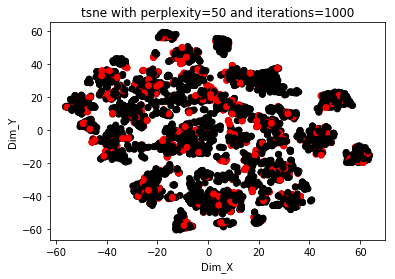

In [134]:
X6=X6.tocsr()
X_5000=X6[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50)
#no of components=2
#learning rate=200
#perplexity=50
#default number of iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=1000")
plt.show()

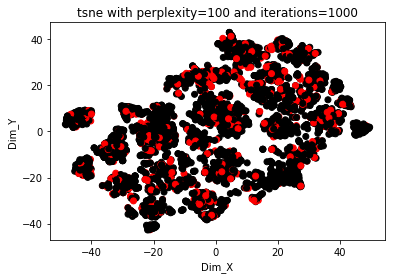

In [135]:
X6=X6.tocsr()
X_5000=X6[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=100)
#no of components=2
#learning rate=200
#erplexity=100
#default number of iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=100 and iterations=1000")
plt.show()

#### There is not much change on changing the perplexity from 30-100; Now let's see what happens on changing the iterations on a fixed perplexity of 50

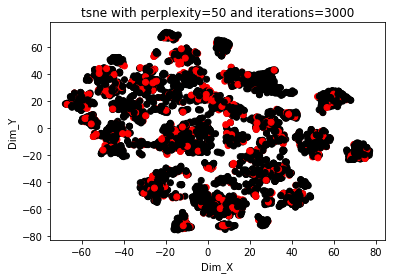

In [136]:
X6=X6.tocsr()
X_5000=X6[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=3000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=3000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=3000")
plt.show()

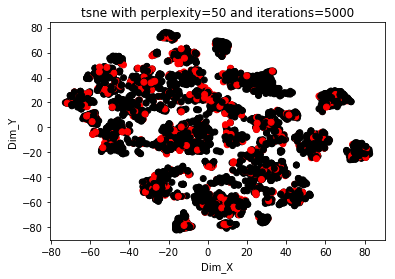

In [137]:
X6=X6.tocsr()
X_5000=X6[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=5000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=5000")
plt.show()

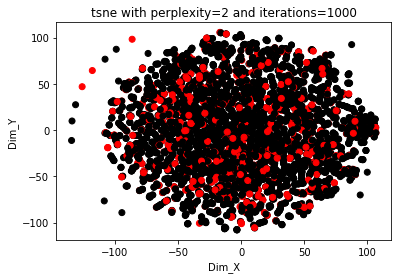

In [138]:
X6=X6.tocsr()
X_5000=X6[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=2,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=2
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=2 and iterations=1000")
plt.show()

### Summary

1. We can see formation of much more clearer custers but still we are unable to derive much information from the plot as the points(red and black) are highly overlapped 

## 6.3 tSNe with average word2vec

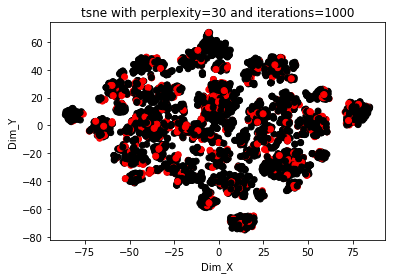

In [139]:
X9=X9.tocsr()
X_5000=X9[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=30,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=30
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

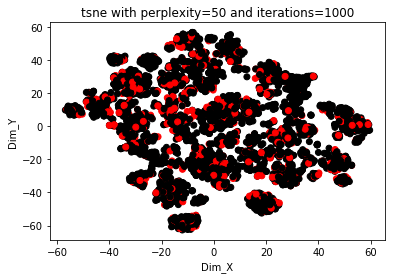

In [140]:
X9=X9.tocsr()
X_5000=X9[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=1000")
plt.show()

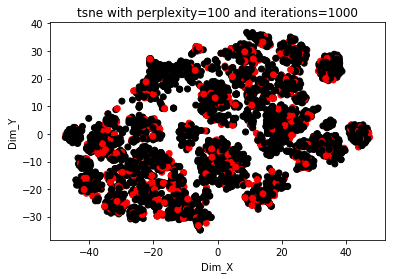

In [141]:
X9=X9.tocsr()
X_5000=X9[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=100,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=100
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=100 and iterations=1000")
plt.show()

#### There is not much change on changing the perplexity from 30-100; Now let's see what happens on changing the iterations on a fixed perplexity of 50

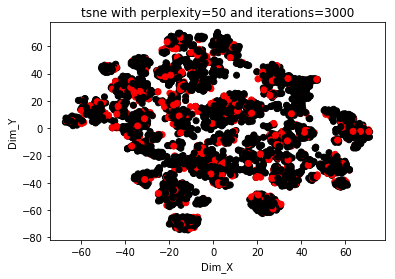

In [142]:
X9=X9.tocsr()
X_5000=X9[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=3000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=3000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=3000")
plt.show()

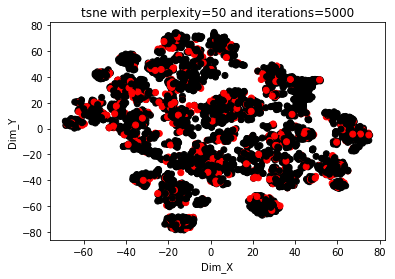

In [143]:
X9=X9.tocsr()
X_5000=X9[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=5000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=5000")
plt.show()

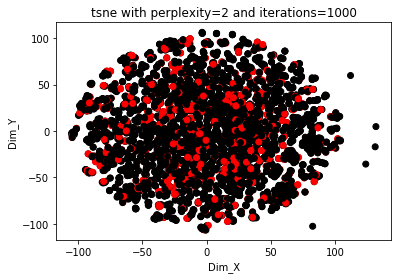

In [144]:
X9=X9.tocsr()
X_5000=X9[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=2,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=2
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=2 and iterations=1000")
plt.show()

### Summary

1. Clusters are formed but points are highly overlapped and therefore can't derive much information

## 6.4 tSNe with tf-idf word2vec

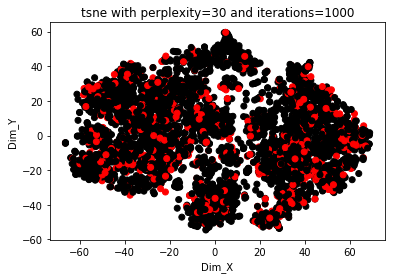

In [145]:
X12=X12.tocsr()
X_5000=X12[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=30,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=30
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

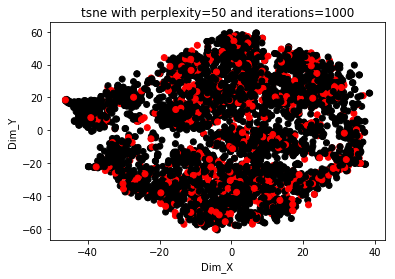

In [146]:
X12=X12.tocsr()
X_5000=X12[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=1000")
plt.show()

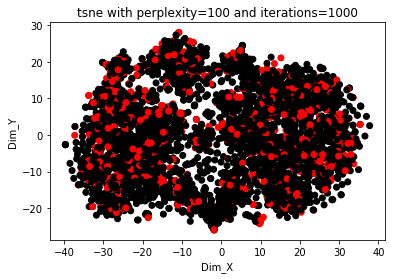

In [147]:
X12=X12.tocsr()
X_5000=X12[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=100,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=100
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=100 and iterations=1000")
plt.show()

#### There is not much change on changing the perplexity from 30-100; Now let's see what happens on changing the iterations on a fixed perplexity of 50

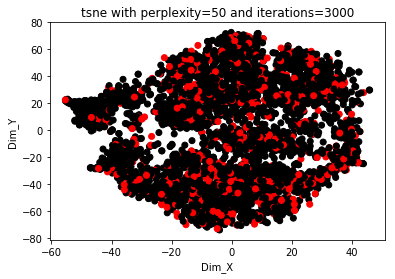

In [148]:
X12=X12.tocsr()
X_5000=X12[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=3000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=3000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=3000")
plt.show()

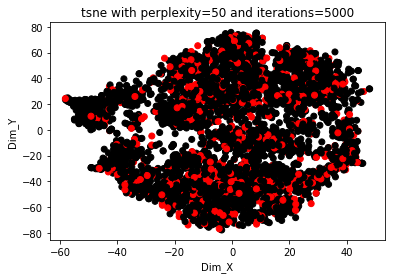

In [149]:
X12=X12.tocsr()
X_5000=X12[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=5000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=5000")
plt.show()

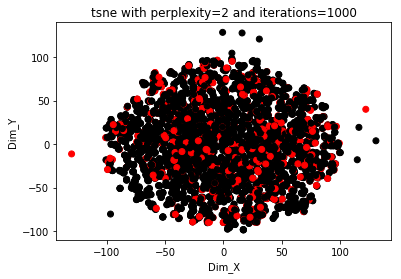

In [150]:
X12=X12.tocsr()
X_5000=X12[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=2,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=2
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=2 and iterations=1000")
plt.show()

### Summary

1. Clusters are formed but points are highly overlapped and therefore can't derive much information

## 6.5 tSNE of all the feature

In [151]:
X=hstack((X3,X6,X9))
print(X.shape)

(109248, 7399)


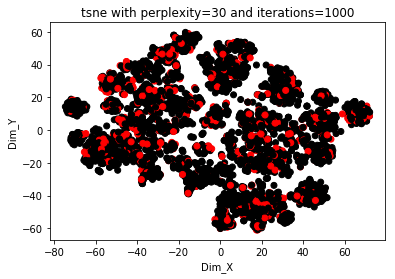

In [152]:
X=X.tocsr()
X_5000=X[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=30,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=30
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=30 and iterations=1000")
plt.show()

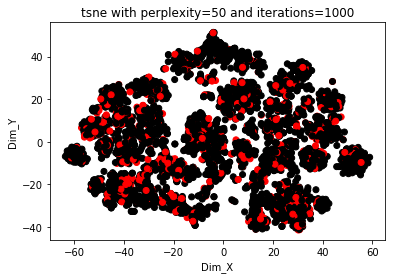

In [153]:
X=X.tocsr()
X_5000=X[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=1000")
plt.show()

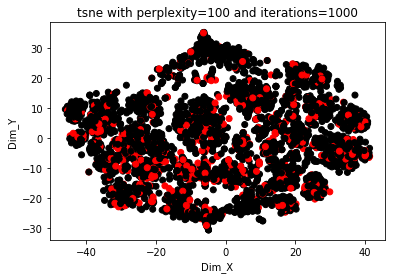

In [154]:
X=X.tocsr()
X_5000=X[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=100,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=100
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=100 and iterations=1000")
plt.show()

#### Perplexity is set to 50 as changing the perplexity the plot is almost same
#### Now changing the number of iterations to see if they make any difference

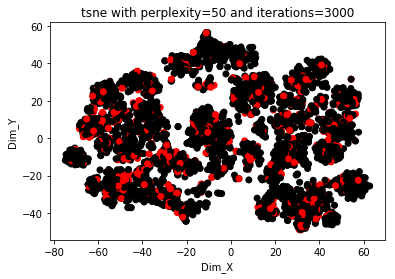

In [155]:
X=X.tocsr()
X_5000=X[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=3000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=3000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=3000")
plt.show()

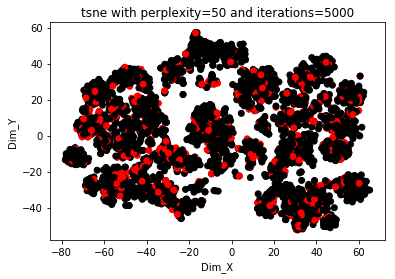

In [156]:
X=X.tocsr()
X_5000=X[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
#no of components=2
#learning rate=200
#perplexity=50
#iterations=5000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=50 and iterations=5000")
plt.show()

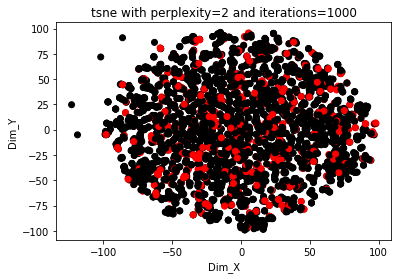

In [157]:
X=X.tocsr()
X_5000=X[0:5000:]
Y_5000=train_data['project_is_approved'][0:5000]
model=TSNE(n_components=2,random_state=0,perplexity=2,n_iter=1000)
#no of components=2
#learning rate=200
#perplexity=2
#iterations=1000
X_embedding=model.fit_transform(X_5000.toarray())

for_tsne = np.hstack((X_embedding, Y_5000.values.reshape(-1,1)))
#creating a dataframe which will help us in plotting the tsne plot
tsne_df=pd.DataFrame(data=for_tsne, columns=['Dim_X','Dim_Y','score'])

#plottting
colors = {0:'red', 1:'black'}
plt.scatter(tsne_df['Dim_X'], tsne_df['Dim_Y'], c=tsne_df['score'].apply(lambda x: colors[x]))
plt.xlabel("Dim_X")
plt.ylabel("Dim_Y")
plt.title("tsne with perplexity=2 and iterations=1000")
plt.show()

## Summary

1. No clear information as the datapoints are highly overlapped
2. Seeing all the tsne plot we can say that have can't accepted or rejected our proposal as they contain nearly same words in our text feature

# 7. Reference

1. https://en.wikipedia.org/wiki/DonorsChoose
2. https://www.kaggle.com/donorschoose/io/version/2#Donors.csv
3. https://www.google.com/search?q=donor+choose&client=firefox-b-d&channel=trow&source=lnms&tbm=isch&sa=X&ved=0ahUKEwi445SX5fziAhXPfH0KHRGFCAwQ_AUIESgC#imgrc=mEsqnyM5gtMSPM: